# Simple regression

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference, simple_cv_adaptation
from pcv.plots import plot_model_results, plot_fold_results, plot_rhats
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

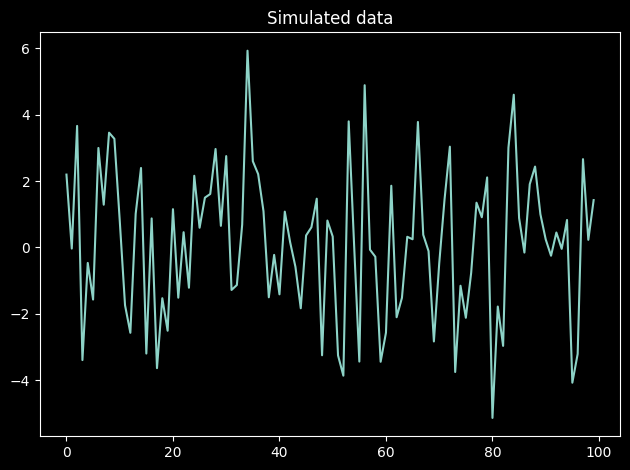

In [3]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.7]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [4]:
K = 10
model = reg.get_model(y, X, K=K)

First, run model diagnostics.

In [5]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=32,
    num_samples=10_000,
    warmup_iter=10_000,
    prior_only=False
)

GHMC alpha: 0.6247, delta: 0.3123, step size: 0.4999


In [6]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.880,0.129,0.636,1.122,0.001,0.000,52627.0,82380.0,1.0
beta[1],0.970,0.123,0.738,1.203,0.000,0.000,70619.0,109156.0,1.0
beta[2],1.005,0.110,0.801,1.215,0.000,0.000,71130.0,109084.0,1.0
beta[3],0.688,0.122,0.459,0.918,0.001,0.000,39707.0,66041.0,1.0
sigsq,1.498,0.216,1.113,1.907,0.001,0.001,61271.0,91486.0,1.0


In [7]:
print(f"Saw {state.divergences.sum()} divergences")

Saw 0 divergences


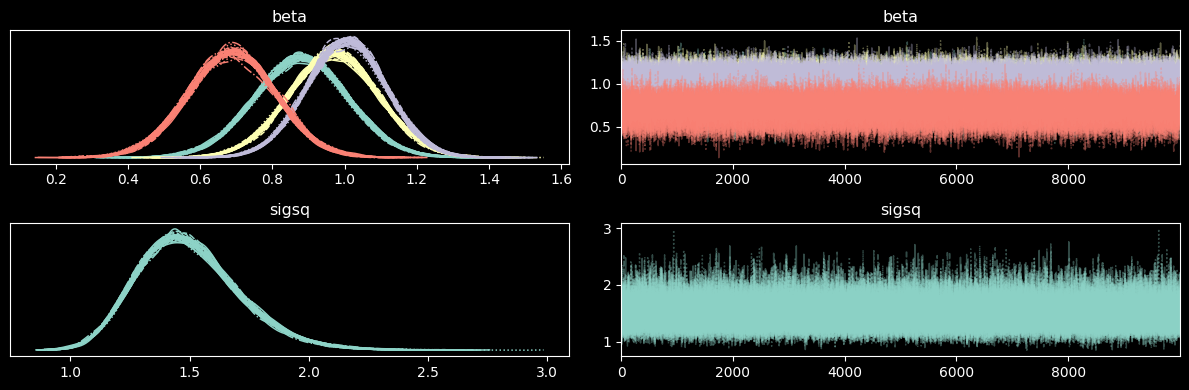

In [8]:
axes = az.plot_trace(idata)
plt.tight_layout()

## Cross-Validation


In [9]:
warmup_results = simple_cv_adaptation(
    prng_key=jax.random.PRNGKey(42),
    model=model,
    warmup_model_id=0,
    num_chains=4,
    adaptation_iter=1_000,
    burnin_iter=500,
    batch_size=100,
)

MEADS warmup for 2 model(s) (8 chains)...
Meads warmup done in 3.82 seconds. 
Step size: 0.4098 Alpha: 0.5298 Delta: 0.2649
Approximated 20 modes in 0 min 0.8 sec
Burn-in for 80 chains run took 0 min 4.8 sec


In [10]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(0),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup_results,
       batch_size=100,
       max_batches=50,
       ignore_stoprule=True,
       prior_only=False
)

Starting cross-validation with 80 parallel GHMC chains...
   0.  Model A: -164.71 ±6.80 ess 9233, Model B: -177.52 ±3.26 ess 8119
       Diff: 12.81 ±5.28, Rhat < 1.0164  stop
       Triggered stoprule after 1 batches in 4 seconds
  10.  Model A: -164.57 ±6.78 ess 23195, Model B: -177.46 ±3.22 ess 22217
       Diff: 12.89 ±5.29, Rhat < 1.0093  stop
  20.  Model A: -164.54 ±6.79 ess 37410, Model B: -177.45 ±3.24 ess 36521
       Diff: 12.91 ±5.29, Rhat < 1.0058  stop
  30.  Model A: -164.54 ±6.82 ess 52112, Model B: -177.48 ±3.24 ess 50404
       Diff: 12.93 ±5.32, Rhat < 1.0037  stop
  40.  Model A: -164.50 ±6.80 ess 66080, Model B: -177.49 ±3.24 ess 64822
       Diff: 12.99 ±5.30, Rhat < 1.0035  stop
  49.  Model A: -164.52 ±6.80 ess 78556, Model B: -177.49 ±3.24 ess 77425
       Diff: 12.98 ±5.30, Rhat < 1.0025  stop
Drew 400000 samples in 1 min 36 sec (4180 per sec)


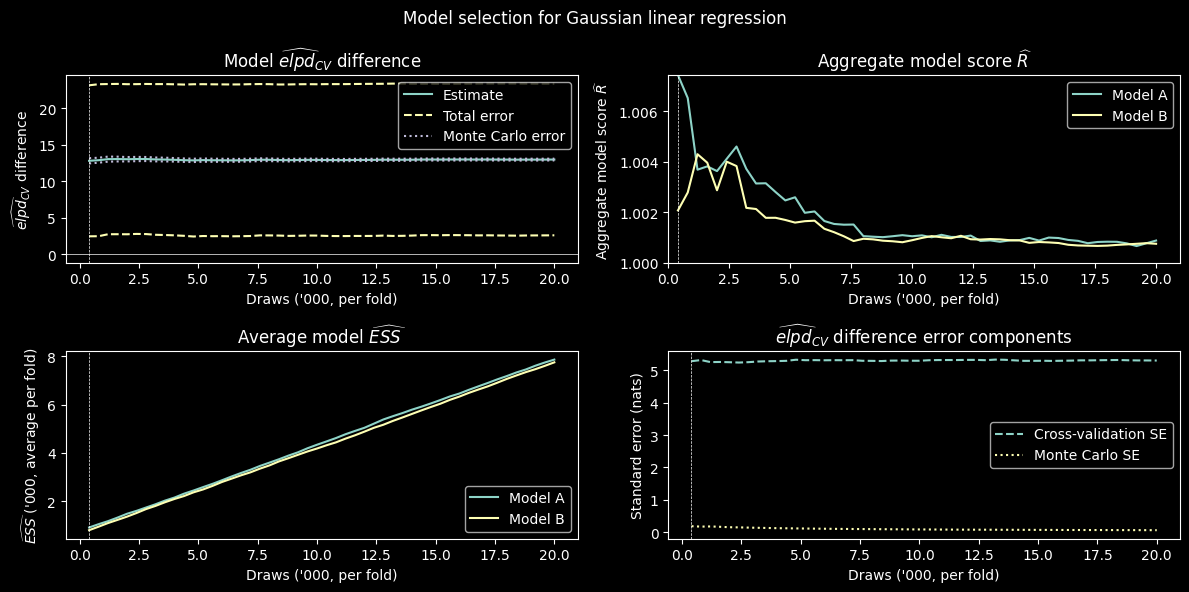

In [11]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

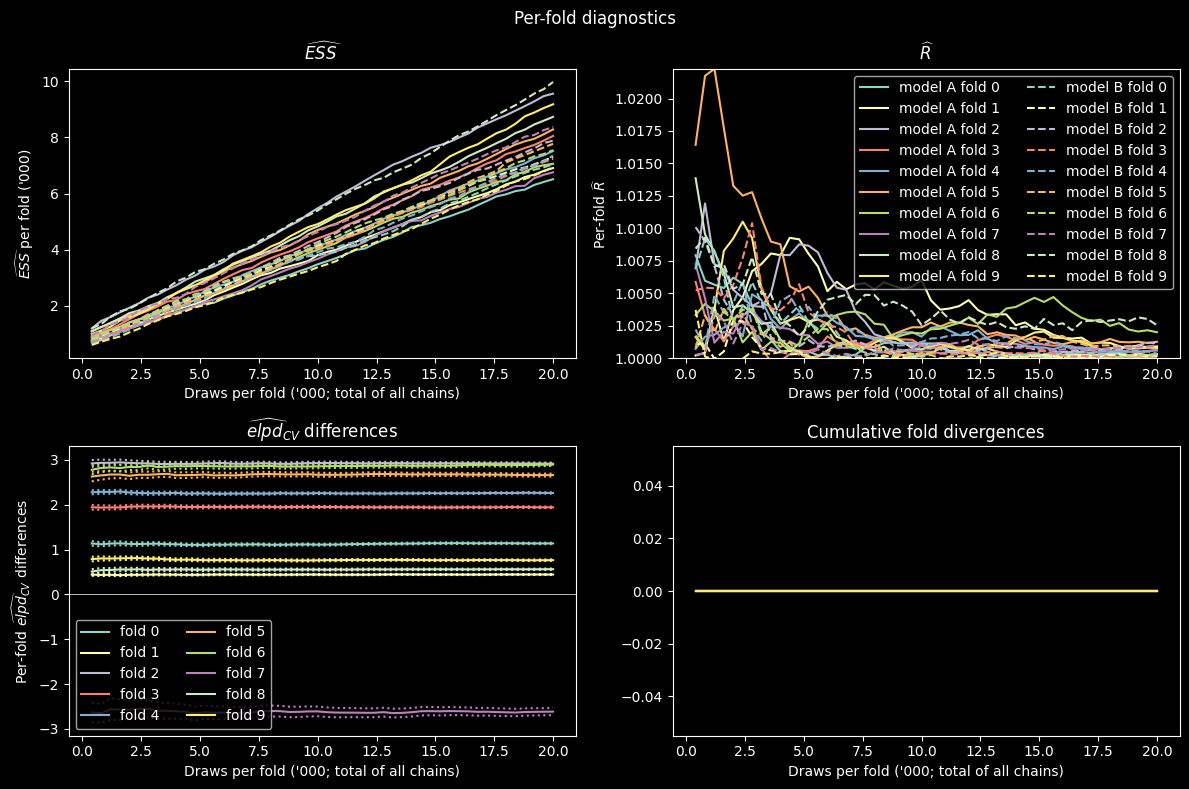

In [12]:
plot_fold_results(results, title='Per-fold diagnostics')

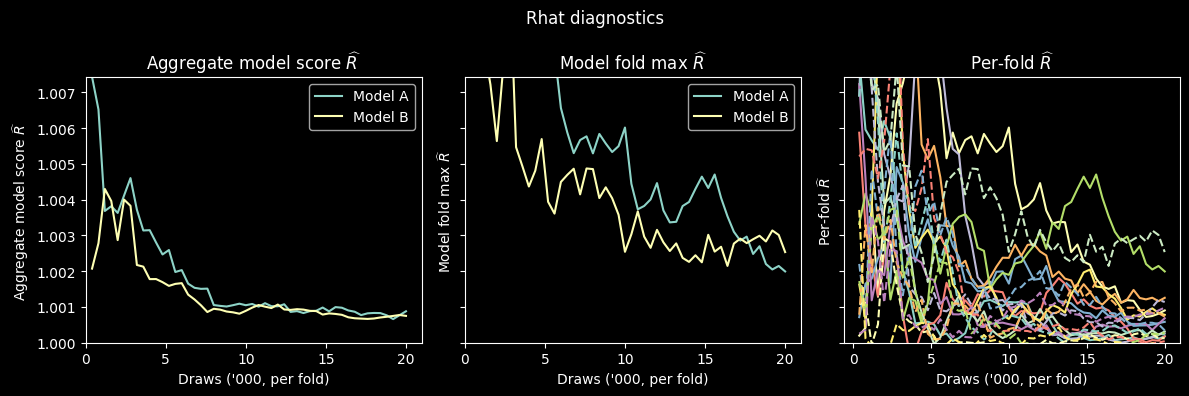

In [13]:
plot_rhats(results)

In [57]:
n = results['fold_draws']
m = results['num_chains']
est_rhat = jnp.sqrt(jnp.expand_dims(n/(n+1), axis=1) + 1.0*m**2/results['fold_ess'])

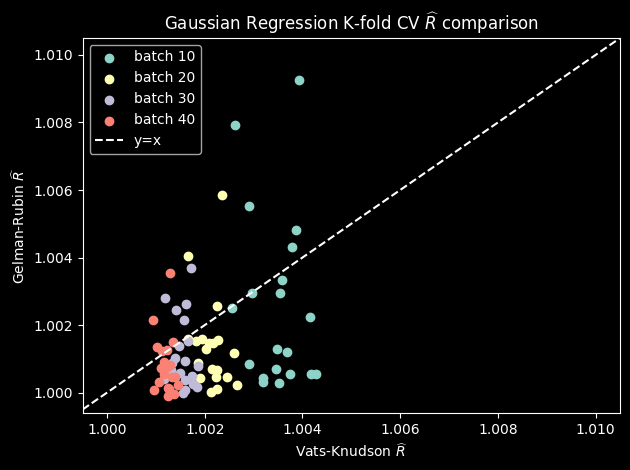

In [58]:
for b in [10, 20, 30, 40]:
    plt.scatter(est_rhat[b, :], results['fold_rhat'][b,:], label=f"batch {b}")
plt.ylabel(r'Gelman-Rubin $\widehat{R}$')
plt.xlabel(r'Vats-Knudson $\widehat{R}$')
plt.title(r'Gaussian Regression K-fold CV $\widehat{R}$ comparison')
plt.axline((1,1), (1.01,1.01), linestyle='--', label='y=x')
plt.legend()
plt.tight_layout()